In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tools import categorical
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

#Tree
from sklearn import tree
from IPython.display import Image

%matplotlib inline
import matplotlib.cm as cm

import seaborn as sns
sns.set_style("dark")

In [2]:
# Base param.
seed = 712


In [3]:
# Load Dataset
financial_data_path = "../data/PS_20174392719_1491204439457_log.csv"
df = pd.read_csv(financial_data_path)

In [4]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
# check null values
df.isnull().values.any()

False

In [6]:
# check the distribution of dataset
print(df.describe())
print(df.info())
print(len(df)) # number of dataset -> 6362620

               step        amount  oldbalanceOrg  newbalanceOrig  \
count  6.362620e+06  6.362620e+06   6.362620e+06    6.362620e+06   
mean   2.433972e+02  1.798619e+05   8.338831e+05    8.551137e+05   
std    1.423320e+02  6.038582e+05   2.888243e+06    2.924049e+06   
min    1.000000e+00  0.000000e+00   0.000000e+00    0.000000e+00   
25%    1.560000e+02  1.338957e+04   0.000000e+00    0.000000e+00   
50%    2.390000e+02  7.487194e+04   1.420800e+04    0.000000e+00   
75%    3.350000e+02  2.087215e+05   1.073152e+05    1.442584e+05   
max    7.430000e+02  9.244552e+07   5.958504e+07    4.958504e+07   

       oldbalanceDest  newbalanceDest       isFraud  isFlaggedFraud  
count    6.362620e+06    6.362620e+06  6.362620e+06    6.362620e+06  
mean     1.100702e+06    1.224996e+06  1.290820e-03    2.514687e-06  
std      3.399180e+06    3.674129e+06  3.590480e-02    1.585775e-03  
min      0.000000e+00    0.000000e+00  0.000000e+00    0.000000e+00  
25%      0.000000e+00    0.000000e+00

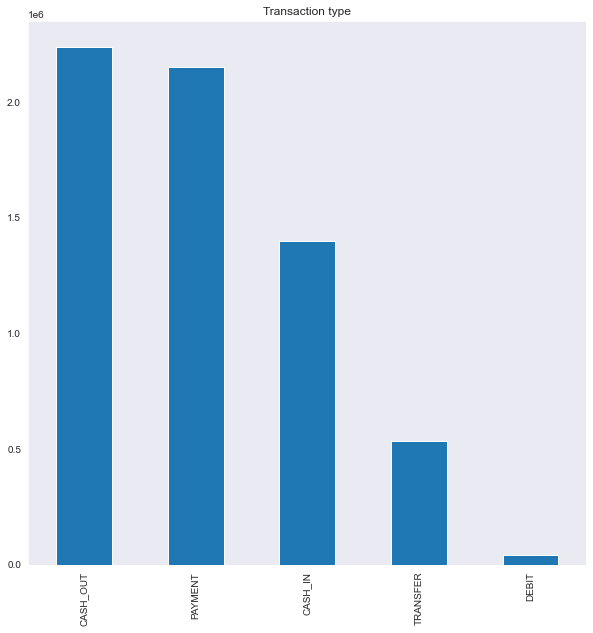

In [7]:
# https://www.kaggle.com/netzone/eda-and-fraud-detection
# EDA
fig, ax = plt.subplots(1,1, figsize=(10,10))
df.type.value_counts().plot(kind="bar", title="Transaction type", ax=ax, figsize=(10, 10))
plt.show()

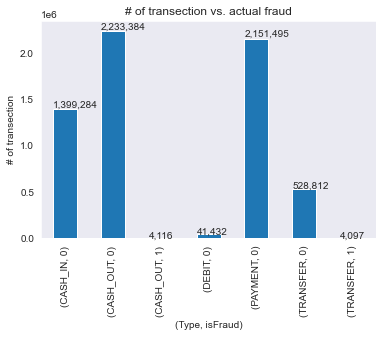

In [8]:
ax = df.groupby(['type', 'isFraud']).size().plot(kind='bar')
ax.set_title("# of transection vs. actual fraud")
ax.set_xlabel("(Type, isFraud)")
ax.set_ylabel("# of transection")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ",d")), (p.get_x(), p.get_height()*1.01))

In [9]:
# remove unnecessary dataset
df_drop = df
df_drop.drop(['step', 'nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1, inplace=True)
df_drop = df_drop.reset_index(drop=True)

In [10]:
type_converter = np.array(df_drop['type'])
type_categorical = categorical(type_converter, drop=True)

In [11]:
df_drop['num_type'] = type_categorical.argmax(1)
# CASH-IN: 0, CASH-OUT: 1, DEBT: 2, PAYMENT: 3, TRANSFER: 4
# df_drop.loc[df_drop['num_type']==0] #find specific num
# df_drop.loc[(df_drop['type'].isin(['TRANSFER', 'CASH_OUT'])), :] #find specific char

In [12]:
fraud_cnt = len(df_drop.loc[df_drop['isFraud']==0])
no_fraud_cnt = len(df_drop.loc[df_drop['isFraud']!=0])

In [13]:
print(len(df_drop))
print(fraud_cnt)
print(no_fraud_cnt)

6362620
6354407
8213


In [14]:
df_drop.drop(['type'], axis=1, inplace=True)

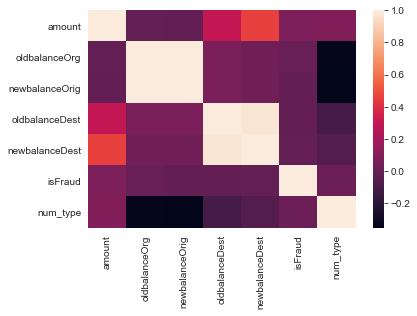

In [15]:
# def correlation_plot(df):
#     fig = plt.figure(figsize=(10, 10))
#     ax1 = fig.add_subplot(111)
#     cmap = cm.get_cmap('jet', 30)
#     cax = ax1.imshow(df.corr(), interpolation = "nearest", cmap = cmap)
#     ax1.grid(True)
#     plt.title("Correlation Heatmap")
#     labels = df.columns.tolist()
#     ax1.set_xticklabels(labels, fontsize=13, rotation=45)
#     ax1.set_yticklabels(labels, fontsize=13)
#     fig.colorbar(cax)
#     plt.show()
    
# correlation_plot(df_drop)

# Alternatively, we can use quick seaborn
# plot the heatmap
sns.heatmap(df_drop.corr())

In [16]:
X = df_drop.loc[:, df_drop.columns != 'isFraud']
y = df_drop.loc[:, df_drop.columns == 'isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=712)
print(f"train num: {len(X_train)}, test num: {len(X_test)}")

train num: 5090096, test num: 1272524


In [17]:
tree_model = tree.DecisionTreeClassifier(max_depth=3, criterion='entropy', random_state=712)
# tree_model.get_params()
tree_model = tree_model.fit(X_train, y_train)

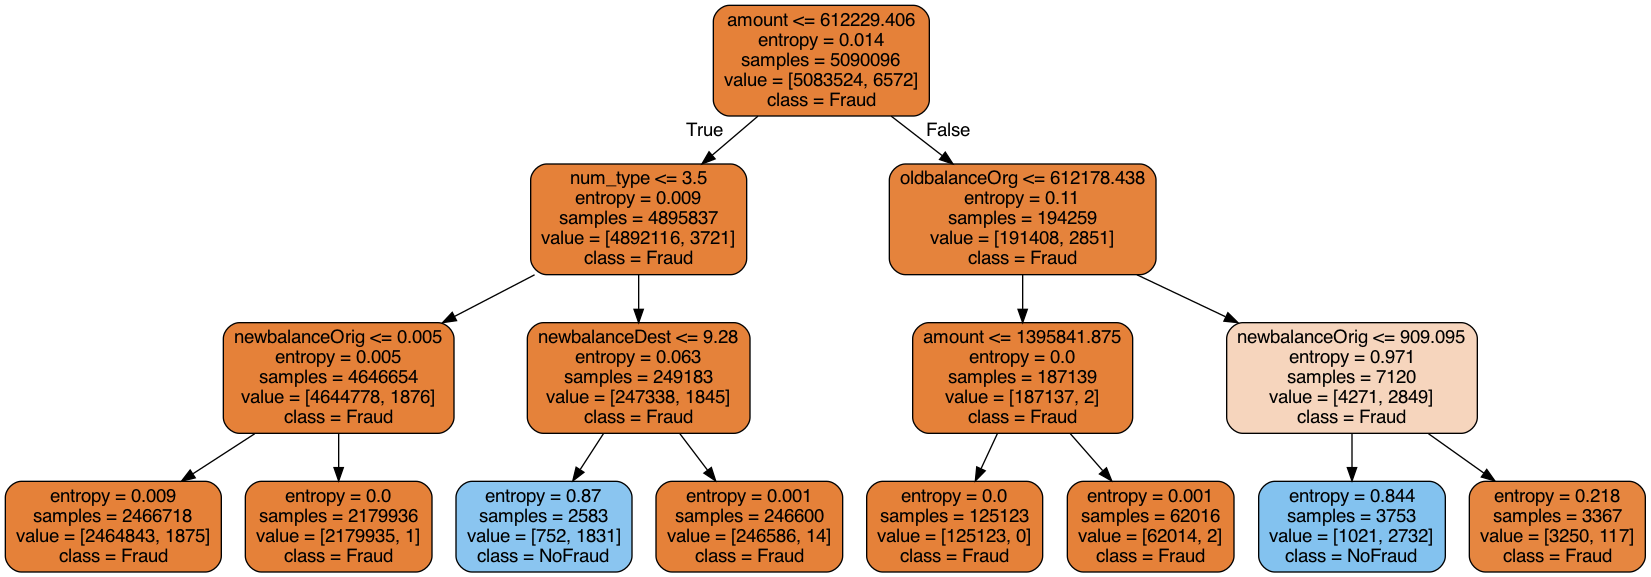

In [18]:
# tree.export_graphviz(tree_model, out_file='fraud_tree.dot', class_names=['Fraud', 'NoFraud'],
#                     feature_names=X_train.columns, filled=True, rounded=True)
# os.system("dot -Tpng fraud_tree.dot -o fraud_tree.png")
# os.system("fraud_tree.png")

Image(filename='fraud_tree.png')

In [19]:
tree_model.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

## Neural Networks. 

For the neural network you should implement or steal your favorite kind of network and training algorithm. You may use networks of nodes with as many layers as you like and any activation function you see fit.

In [20]:
nn_model = MLPClassifier(hidden_layer_sizes=(10,10), activation='logistic', solver='sgd',
                        alpha=0.01, learning_rate_init=0.1, random_state=712)

In [21]:
nn_model.fit(X_train, y_train)

/Users/user/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


MLPClassifier(activation='logistic', alpha=0.01, hidden_layer_sizes=(10, 10),
              learning_rate_init=0.1, random_state=712, solver='sgd')

In [22]:
y_pred_test = nn_model.predict(X_test)

## Boosting. 
Implement or steal a boosted version of your decision trees. As before, you will want to use some form of pruning, but presumably because you're using boosting you can afford to be much more aggressive about your pruning.

## Support Vector Machines.
You should implement (for sufficiently loose definitions of implement including "download") SVMs. This should be done in such a way that you can swap out kernel functions. I'd like to see at least two.

## k-Nearest Neighbors.
You should "implement" (the quotes mean I don't mean it: steal the code) kNN. Use different values of k.

## Testing. 

In addition to implementing (wink) the algorithms described above, you should design two interesting classification problems. For the purposes of this assignment, a classification problem is just a set of training examples and a set of test examples. I don't care where you get the data. You can download some, take some from your own research, or make some up on your own. Be careful about the data you choose, though. You'll have to explain why they are interesting, use them in later assignments, and come to really care about them.